<a href="https://colab.research.google.com/github/anajikadam/Head-Based-Classification-/blob/main/HeadBased_TextClassification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Head-based Text Classification with BERT


<!-- https://freedium.cfd/https://medium.com/@hugmanskj/hands-on-head-based-text-classification-with-bert-0a1775d5db9d -->

## **head-based** classification in natural language processing (NLP) tasks

 In NLP, tasks such as sentence or document classification are pivotal for a wide range of applications, from sentiment analysis to topic detection.

## What is Head-Based Classification?
Head-based classification involves appending a "head" (a layer or set of layers of a neural network) to a pre-trained model to carry out a specific task, such as classifying the topics of texts. In this scenario, the "head" is optimized to output predictions for the classification task, effectively leveraging the rich representations learned by the network from ample data to adeptly address the problem at hand - in this case, classification.
By employing a head-based approach, we can fine-tune the pre-trained model on a relatively small dataset tailored to our specific task, making this method highly versatile and applicable across a wide range of natural language processing (NLP) challenges.

head-based classification means adding a specialized layer or set of layers to a pre-trained model to help it classify things. Imagine you have a smart brain that knows a lot about many things. Now, you add a new section to this brain that specifically helps it decide and classify different topics. This new section, or "head," takes advantage of what the brain already knows to make accurate guesses about new topics it sees. It's like giving the brain a new skill without having to teach it everything from scratch.

### Head-Based Classification with BERT and the `[CLS]` Token

In the BERT model, the [CLS] token plays a pivotal role in sequence-level tasks such as classification. This section will provide a step-by-step explanation of the interaction between the [CLS] token and the classification head.

1. **Pre-trained BERT Initialization:** Begin by preparing a BERT model that has been pre-trained on extensive text corpora, typically downloaded using tools like Hugging Face. This model already possesses the capability to understand language to a certain extent, including grammar, context, and semantics across a broad domain.

2. **Adding the [CLS] Token:** For each input sequence, a [CLS] token is added at the beginning. In standard BERT usage, initiating the tokenizer automatically adds a [CLS] dummy token at the forefront of the returned sequence. The hidden states corresponding to this [CLS] token, as the sequence passes through BERT's layers, aggregate contextual information from the input, condensing the entire sequence into a succinct vector representation.

3. **Designing the Classification Head:** The vector corresponding to the [CLS] token's position from the top layer of BERT is extracted and connected to the classification head. This head is typically a simple neural network culminating in a softmax layer, mapping the rich representation of the [CLS] token to specific class labels.

4. **Fine-Tuning:** The combined model, consisting of BERT and the classification head, is fine-tuned on a dataset tailored to the specific classification task. This stage optimizes both the parameters of BERT and the classification head to ensure optimal performance for the intended application.

<img src="https://www.dropbox.com/scl/fi/xj5ms31eas7kknmqotzp1/head_classification_bert.png?rlkey=1dc5ip0a6pz1tm0jsq8wqvkf1&dl=1" width="500px"></img>

## Preview of Implementations

### Topic Classification with BERT on AG News Dataset

**Objective:**  
- Train a BERT model for topic classification using the AG News dataset, part of the GLUE benchmark.
- Evaluate model performance using metrics like accuracy, precision, recall, and F1 score, and visualize the results with a confusion matrix.

**Dataset:**  
- The AG News dataset, which is included in the GLUE benchmark, consists of news articles divided into four categories, providing a rich dataset for classification.

**Tools and Libraries:**  
- **PyTorch**: Utilized for model training, evaluation, and inference processes.
- **Transformers Library**: Provides access to pre-trained BERT models, facilitating the use of advanced NLP techniques.

**Model Design:**  
- The core of our implementation will utilize a pre-trained BERT model from the Transformers library. A classification head will be added on top of BERT to adapt it to our topic classification task, reflecting the four categories in the AG News dataset.

**Training Loop:**  
- The training process involves fine-tuning the pre-trained BERT model with our dataset.
- The loop will also include evaluation phases to monitor the model's performance on a validation set, helping us to fine-tune hyperparameters and prevent overfitting.

**Evaluation Metrics:**  
- Metrics such as accuracy, precision, recall, and F1 score will be used to evaluate the model's performance across the classification tasks.
- Furthermore, we will analyze the results with a confusion matrix.

## Import Libraries
Import necessary libraries for data loading, model building, training, and evaluation. This step is crucial because it prepares our environment with the necessary tools and libraries required for our specific task. It's like gathering all the ingredients before you start cooking.

In [1]:
!pip install -qqq seaborn # for evaluation visualization
!pip install -qqq wandb   # for logging
!pip install -qqq datasets # huggingface's lib.
!pip install -qqq transformers==4.39.2
!pip install -qqq accelerate==0.28.0
!pip install -qqq shortuuid

!pip install -U accelerate
!pip install tensorboard

  Using cached accelerate-0.31.0-py3-none-any.whl (309 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.28.0
    Uninstalling accelerate-0.28.0:
      Successfully uninstalled accelerate-0.28.0


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import torch
import random
import os

# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()


## Load Dataset

The **AG News dataset** is widely used for topic classification tasks due to its well-balanced classes, diverse range of topics, and substantial size.

For more details, visit the AG News dataset page: [AG News Dataset Information](https://huggingface.co/datasets/ag_news)



In [3]:
dataset = load_dataset("ag_news")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [6]:
print(type(dataset))
from datasets import DatasetDict

test_size = 0.7

# Taking 60% random samples from the 'train' and 'test' datasets
train_sampled = dataset['train'].train_test_split(test_size=test_size, seed=42)['train']  #120000-(120000*0.7) = 36000.0
test_sampled = dataset['test'].train_test_split(test_size=test_size, seed=42)['train']

# Creating a new DatasetDict with the sampled datasets
sampled_dataset = DatasetDict({
    'train': train_sampled,
    'test': test_sampled
})

sampled_dataset


<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 36000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2280
    })
})

In [7]:
dataset = sampled_dataset

In [8]:
from pprint import pprint # Using Python's pprint (pretty-print) library to prevent long horizontal output and make the data more readable

print(type(dataset)) # Data type
print(dataset) # Data structure and count
print("\n"*2+ "Train dataset:")
pprint(dataset["train"][1]) # Print to check the content of train data

# Explanation of labels - 4 classes # https://huggingface.co/datasets/ag_news
# 1 class: World news
# 2 class: Sports news
# 3 class: Business news
# 4 class: Science/Technology news

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 36000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2280
    })
})


Train dataset:
{'label': 0,
 'text': "Bethlehem's Paradise Hotel Opens Doors (AP) AP - The floors are "
         'polished, a Christmas tree glitters near the bar and the dining room '
         'is ready for hundreds of guests: The luxury Paradise Hotel is open '
         'for business for the first time since the latest Palestinian '
         'uprising erupted in 2000.'}


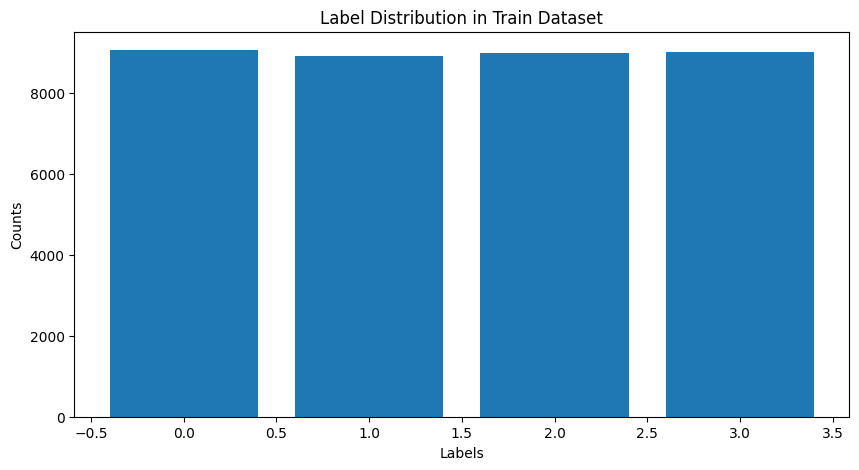

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_label_distribution(dataset, dataset_name):
    # Count the occurrences of each label
    label_counts = Counter(dataset['label'])

    # Extract labels and their corresponding counts
    labels, counts = zip(*label_counts.items())

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Label Distribution in {dataset_name} Dataset')
    plt.show()

# Check label distribution in the sampled train and test datasets
plot_label_distribution(dataset["train"], 'Train')
# plot_label_distribution(sampled_dataset_dict['test'], 'Test')


### Initialize Tokenizer and Preprocess Data

The tokenizer converts text into tokens that can be fed into the BERT model. This step is essential for preparing our data in a format that the model can understand.


In [11]:
pretrained_model = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(pretrained_model)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2280 [00:00<?, ? examples/s]

### Data Collator

A data collator is responsible for batching together data samples. In this context, it ensures that all input sequences in a batch are padded to the same length, which is a requirement for processing by the BERT model.


In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Data Handling Flow in Hugging Face
In most cases, the flow in Hugging Face follows `dataset`→ `mapping function` → `data collator` → `data loader`.

1. **dataset**: Manages data objects like the AG News dataset.
2. **mapping function**: Implements functions to transform raw text into a format understandable by the model through tokenization and preprocessing, or other preprocessing functions. Usually, developers customize this according to their data.
3. **data collator**: Essential for handling variable-length sequences, dynamically padding batches to ensure uniformity and facilitate smooth model input. Typically, Hugging Face provides data processing functionalities corresponding to the model type (e.g., Seq2Seq model, TokenClassification, Causual_LM, etc.), which are already implemented and distributed. Developers can also write their own if necessary.
4. **data loader**: The final step that prepares data for the model by batching, shuffling, and creating an optimized iterable for training or evaluation.

Following this flow for coding, developers can expect high code readability and reusability when utilizing different datasets or models, becoming familiar with this pattern.


## Training

With data ready, we'll proceed to the model's training phase, structured as follows:

1. **Define Model**: Load BERT and attach a classification layer tailored to our topics.
2. **Training Arguments**: Set parameters like epochs, batch size, and learning rate.
3. **Training Loop**: Iterate over data, adjusting weights to improve topic classification accuracy.
4. **Evaluation**: Test the model's performance on unseen data to ensure reliability.

This streamlined approach prepares us for effective model training and evaluation.



### Define Model

Here we initialize the BERT model for sequence classification. The `num_labels=4` indicates that we are dealing with a classification problem with four possible outcomes, corresponding to the number of topics in the AG News dataset.


In [13]:
model = BertForSequenceClassification.from_pretrained(pretrained_model, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Arguments

Training arguments define various parameters for the training process such as the number of epochs, batch size, learning rate adjustments, and where to save logs and outputs.


In [14]:
training_args = TrainingArguments(
    output_dir='./results-bert-topic-cls',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',

    evaluation_strategy='epoch',  # Evaluate at the end of each epoch
    logging_steps=10,
    ## ----
    report_to="tensorboard",
)

### Training Loop and Evaluation
Define a compute_metrics function for evaluation:

In [15]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


Initialize Trainer and train:

In [16]:
# Select the first N samples from the tokenized training dataset
subset_train_dataset = tokenized_datasets['train'].select(range(6000)) # 1/2 data for time saving

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=subset_train_dataset,
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.388800,0.323261,0.894298,0.893728,0.893642,0.894298
2,0.245600,0.297399,0.906140,0.905466,0.906239,0.906140
3,0.145600,0.305589,0.903509,0.903493,0.903787,0.903509


TrainOutput(global_step=564, training_loss=0.42304318836817506, metrics={'train_runtime': 1119.2237, 'train_samples_per_second': 16.083, 'train_steps_per_second': 0.504, 'total_flos': 3254577752424960.0, 'train_loss': 0.42304318836817506, 'epoch': 3.0})

For a quick learning demonstration, we've conducted training for only up to 3 epochs. Even without fine-tuning hyperparameters, we can observe that the training achieved approximately 90% accuracy.

### Saving the model

We'll save the recently trained model and tokenizer. By saving them, we can easily use them later in a pipeline, which I'll explain further in the later.

In [18]:
# Specify the directory where you want to save your model
output_dir = './bert-topic-cls'

# Save the model
model.save_pretrained(output_dir)
# Save the tokenizer
tokenizer.save_pretrained(output_dir)

('./bert-topic-cls/tokenizer_config.json',
 './bert-topic-cls/special_tokens_map.json',
 './bert-topic-cls/vocab.txt',
 './bert-topic-cls/added_tokens.json')

## Evaluation and Analysis
After training, evaluate the model and plot the confusion matrix:

In [19]:
# Evaluate the model
results = trainer.evaluate()

In [20]:
results

{'eval_loss': 0.305588960647583,
 'eval_accuracy': 0.9035087719298246,
 'eval_f1': 0.9034926807767162,
 'eval_precision': 0.903787268678506,
 'eval_recall': 0.9035087719298246,
 'eval_runtime': 36.8454,
 'eval_samples_per_second': 61.88,
 'eval_steps_per_second': 7.735,
 'epoch': 3.0}

In [21]:
# Predictions to get the confusion matrix
predictions = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions.predictions, axis=-1)

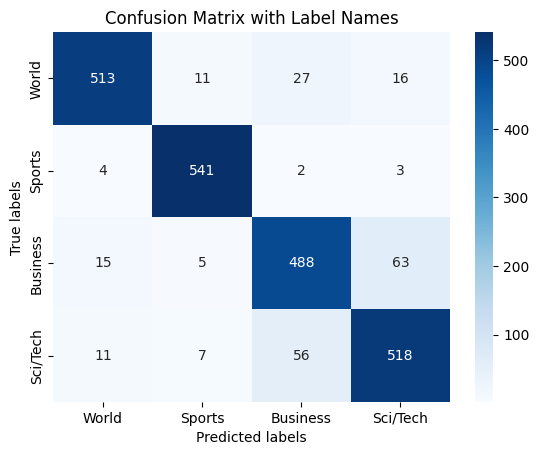

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_map = {
    'LABEL_0': 'World',
    'LABEL_1': 'Sports',
    'LABEL_2': 'Business',
    'LABEL_3': 'Sci/Tech'
}

cm = confusion_matrix(predictions.label_ids, preds)

# label_map to labels
labels = [label_map[f'LABEL_{i}'] for i in range(len(label_map))]

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Label Names')
plt.show()

### Confusion Matrix

Another way to closely examine classification performance is through the Confusion Matrix. The Confusion Matrix is a highly useful tool for evaluating the performance of models in classification problems. It visually represents the accuracy of predictions by basing on the actual and the model-predicted classes. The matrix is structured with actual classes as rows and predicted classes as columns, where the value in each cell represents the number of samples belonging to the corresponding class combination.

The principal diagonal of the Confusion Matrix (diagonal from the top left to the bottom right) represents the cases where the model has made correct predictions, i.e., True Positives (TP) and True Negatives (TN). In contrast, the off-diagonal elements represent errors: False Positives (FP) indicate cases where the model incorrectly predicted a negative class as positive, and False Negatives (FN) indicate cases where the model incorrectly predicted a positive class as negative.

Through the Confusion Matrix, not only the accuracy but also other important performance metrics such as Precision, Recall, and F1 score can be calculated. These metrics offer a more detailed evaluation of the model's performance and are particularly helpful in understanding the performance of models on imbalanced datasets.

### Topic Prediction

In [23]:
# Example sentence
sentence = "The stock market is reaching new heights."

# Tokenize the sentence
inputs = tokenizer(sentence, padding=True, truncation=True, max_length=512, return_tensors="pt")

Make a Prediction

In [24]:
import torch
from transformers import pipeline

In [25]:

# Move inputs to the same device as the model
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Make prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(-1).item()  # Get the predicted class (index)

# Map the prediction index to the class name (if you have a label map)
simple_label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
predicted_label = simple_label_map[predictions]

print(f"Sentence: '{sentence}'")
print(f"Predicted Label: '{predicted_label}'")

Sentence: 'The stock market is reaching new heights.'
Predicted Label: 'Business'


Or you can use huggingface's pipeline

In [26]:

# Specify the path to your fine-tuned model or use a pre-trained model from the Hugging Face Model Hub
model_path = './bert-topic-cls'  # Change this to your model's path or a Hugging Face model name

# Load the pipeline for text classification
classifier = pipeline("text-classification", model=model_path, tokenizer=model_path)

In [27]:
# Example sentences
sentences = [
    "The stock market is reaching new heights.",
    "The new sports car has been unveiled at the auto show.",
    "The tech company announced its latest gadget yesterday."
]

# Make predictions
predictions = classifier(sentences)

# Print the predictions using the label map
for sentence, prediction in zip(sentences, predictions):
    # Map the predicted label to the actual class name
    class_name = label_map[prediction['label']]
    print(f"Sentence: '{sentence}'")
    print(f"Predicted Label: '{class_name}' with score {prediction['score']:.4f}\n")

Sentence: 'The stock market is reaching new heights.'
Predicted Label: 'Business' with score 0.9894

Sentence: 'The new sports car has been unveiled at the auto show.'
Predicted Label: 'Business' with score 0.8611

Sentence: 'The tech company announced its latest gadget yesterday.'
Predicted Label: 'Sci/Tech' with score 0.9323



In [ ]:
# World: "The United Nations convened for a global summit on climate change."
# Sports: "The national soccer team won the championship after a thrilling overtime."
# Business: "The company's quarterly earnings report exceeded market expectations."
# Sci/Tech: "Researchers discovered a new method for efficient solar energy conversion."
# World: "Political tensions escalated between neighboring countries over border disputes."
# Sports: "A new world record was set in the men's 100-meter sprint at the Olympics."
# Business: "The startup secured a record-breaking investment from venture capitalists."
# Sci/Tech: "Scientists published findings on the potential benefits of gene-editing technology."
# World: "The humanitarian crisis in war-torn regions worsened despite international aid efforts."
# Sports: "The tennis prodigy clinched victory in a grueling five-set match at Wimbledon."

In [28]:
# Example sentences
sentences = [
    "The United Nations convened for a global summit on climate change.",
    "The national soccer team won the championship after a thrilling overtime.",
    "The company's quarterly earnings report exceeded market expectations.",
    "Researchers discovered a new method for efficient solar energy conversion.",
    "Political tensions escalated between neighboring countries over border disputes.",
    "A new world record was set in the men's 100-meter sprint at the Olympics.",
    "The startup secured a record-breaking investment from venture capitalists.",
    "Scientists published findings on the potential benefits of gene-editing technology.",
    "The humanitarian crisis in war-torn regions worsened despite international aid efforts.",
    "The tennis prodigy clinched victory in a grueling five-set match at Wimbledon."
]

# Make predictions
predictions = classifier(sentences)

# Print the predictions using the label map
for sentence, prediction in zip(sentences, predictions):
    # Map the predicted label to the actual class name
    class_name = label_map[prediction['label']]
    print(f"Sentence: '{sentence}'")
    print(f"Predicted Label: '{class_name}' with score {prediction['score']:.4f}\n")

Sentence: 'The United Nations convened for a global summit on climate change.'
Predicted Label: 'Sci/Tech' with score 0.9712

Sentence: 'The national soccer team won the championship after a thrilling overtime.'
Predicted Label: 'Sports' with score 0.9938

Sentence: 'The company's quarterly earnings report exceeded market expectations.'
Predicted Label: 'Business' with score 0.9920

Sentence: 'Researchers discovered a new method for efficient solar energy conversion.'
Predicted Label: 'Sci/Tech' with score 0.9626

Sentence: 'Political tensions escalated between neighboring countries over border disputes.'
Predicted Label: 'World' with score 0.9924

Sentence: 'A new world record was set in the men's 100-meter sprint at the Olympics.'
Predicted Label: 'Sports' with score 0.9802

Sentence: 'The startup secured a record-breaking investment from venture capitalists.'
Predicted Label: 'Business' with score 0.8794

Sentence: 'Scientists published findings on the potential benefits of gene-edi